<a href="https://colab.research.google.com/github/DGendooLab/scGPT-GBM-classifier/blob/main/final_analysis/scGPT_Embedding_Tasks_GBM_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Glioblastoma scGPT Classifier (Full Analysis)

## Introduction

Based off the
[scGPT GitHub](https://www.github.com/bowang-lab/scGPT/blob/main/tutorials/zero-shot/Tutorial_ZeroShot_Reference_Mapping.ipynb/) tutorial.

### IMPORTANT:
Connect to a runtime (L4 is recommended for speed + cost) then:

__Tools -> Command Pallete -> "Use fallback runtime version" as scGPT is currently only available for Python<3.11 and Google Colab has been updated to Python 3.11__  

With Google Colab Pro - Use L4 GPU (cheaper) or A100 GPU (faster for embedding tasks).

Use the scGPT-GBM workflow for T4 GPU (Google Colab Free) if you want to test without a subscription.

Pip Freeze Packages (Python 3.10.12) -> LAST CELL OF NOTEBOOK

In [3]:
# connecting to your own google drive (not mandatory unless you want to generate UMAPs in the Post Processing script)

from google.colab import drive
drive.mount('/content/drive')

!python3 --version # should return Python 3.10.12, if not make sure to follow instructions above to "Use Fallback Version"

Mounted at /content/drive
Python 3.10.12


In [8]:
import os
import sys
import requests

if "google.colab" in sys.modules:
    print("Running on Google Colab")
    print("Installing dependencies...")

    !pip install --upgrade scgpt
    !pip install wandb louvain faiss-gpu

    # Install wget for downloading files from URLs
    !apt-get install wget

    # Install gdown for Google Drive downloads
    !pip install -q -U gdown

    print("Downloading scGPT model checkpoint via Google Drive...")
    model_dir = "/content/save/scGPT_continual"
    if not os.path.exists(model_dir):
        !mkdir -p $model_dir
        import gdown
        gdown.download_folder(
            #  human 33M
            # "https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y",

            # brain 10M
            # "https://drive.google.com/drive/folders/1vf1ijfQSk7rGdDGpBntR5bi5g6gNt-Gx",

            # continual pretrained (batch corrected)
            "https://drive.google.com/drive/folders/1_GROJTzXiAV8HB4imruOTk6PEGuNOcgB",
            output=model_dir,
            quiet=False
        )

    print("Setup complete!")

Running on Google Colab
Installing dependencies...
  Using cached scgpt-0.2.1-py3-none-any.whl.metadata (8.8 kB)
  Using cached cell-gears-0.0.2.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached orbax-0.1.7-py3-none-any.whl.metadata (1.9 kB)
  Using cached scanpy-1.10.4-py3-none-any.whl.metadata (9.3 kB)
  Using cached scib-1.1.7-1-py3-none-any.whl.metadata (9.8 kB)
  Using cached scikit_misc-0.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.0 kB)
  Using cached scvi_tools-0.20.3-py3-none-any.whl.metadata (9.8 kB)
  Using cached torch-2.1.2-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached torchtext-0.18.0-cp310-cp310-manylinux1_x86_64.whl.metadata (7.9 kB)
  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached dcor-0.6-py3-none-

In [4]:
print("Downloading Richards et al 2021 GBM data and GBMAP filtered data via Google Drive...")

data_dir = "/content/data"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
    # from google drive folder

    gdown.download_folder(
        "https://drive.google.com/drive/folders/1LfHupXfZPAcLj-xyttfIHsl0FAHlGKUJ",
        output=os.path.join(data_dir),
    )


Retrieving folder contents


Retrieving folder 11buQNvcbXUFZLC62KokubsI7ZU4hK9rc neftel
Processing file 16jj_JWkTtJR1T54YjG7qzrCCNvZlMJHr Neftel2019_data.h5ad
Retrieving folder 1pageW4GT6yKnYRfdg2whzfBBwTO2kjhC richards
Processing file 161Zvl59bOIzyPf0Zgqu8uuuQmaU1vhHK Richards2021_data.h5ad
Processing file 1Cj3Cp0CdZjI47FrCLvu25oNrX0-EYchQ gbm_filtered.h5ad


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=16jj_JWkTtJR1T54YjG7qzrCCNvZlMJHr
From (redirected): https://drive.google.com/uc?id=16jj_JWkTtJR1T54YjG7qzrCCNvZlMJHr&confirm=t&uuid=38f8a218-c19e-4c95-9786-f80bb06596d0
To: /content/data/neftel/Neftel2019_data.h5ad
100%|██████████| 3.18G/3.18G [00:47<00:00, 67.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=161Zvl59bOIzyPf0Zgqu8uuuQmaU1vhHK
From (redirected): https://drive.google.com/uc?id=161Zvl59bOIzyPf0Zgqu8uuuQmaU1vhHK&confirm=t&uuid=31ea5e03-8786-4794-811d-88ae1eaeb575
To: /content/data/richards/Richards2021_data.h5ad
100%|██████████| 5.90G/5.90G [01:44<00:00, 56.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Cj3Cp0CdZjI47FrCLvu25oNrX0-EYchQ
From (redirected): https://drive.google.com/uc?id=1Cj3Cp0CdZjI47FrCLvu25oNrX0-EYchQ&confirm=t&uuid=ceaa2d4c-1142-407b-92c1-ae5e9b6

## Import scGPT and dependencies

In [10]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys

sys.path.insert(0, "../")

import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
    print("faiss imported!")
    print(faiss.__version__)

except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=ImportWarning)


faiss imported!
1.7.2


## Loading Data
Downloaded data can be found in cells above or [here](https://drive.google.com/drive/folders/1LfHupXfZPAcLj-xyttfIHsl0FAHlGKUJ)

In [ ]:
# Reading in data
gbmap = sc.read_h5ad("/content/data/gbm_filtered.h5ad")
adata_train = gbmap

richards = sc.read_h5ad("/content/data/richards/Richards2021_data.h5ad")
richards.X = richards.raw.X.copy()
adata_test = richards

cell_type_key = "annotation_level_3"
# cell_type_key = "cell_type"
gene_col = "feature_name"

# Print the number of cells for adata_train and adata_test
num_cells_train = adata_train.n_obs
print(f"Number of cells - adata_train: {num_cells_train}")

num_cells_test = adata_test.n_obs
print(f"Number of cells - adata_test: {num_cells_test}")

import torch
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*16
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')


Number of cells - adata_train: 298079
Number of cells - adata_test: 40485
GPU mem:24G, batch_size:384


In [ ]:
# Get the counts of each cell type in 'annotation_level_3'
cell_type_counts = adata_train.obs['annotation_level_3'].value_counts()

# Print the counts
print(cell_type_counts)

annotation_level_3
TAM-BDM            54884
CD4/CD8            53168
AC-like            43800
TAM-MG             38101
MES-like           32458
NPC-like           21742
OPC-like           17208
Mono               13876
Oligodendrocyte     9016
DC                  3729
RG                  2807
NK                  2414
Mural cell          1403
B cell              1206
Endothelial          631
Plasma B             572
OPC                  496
Mast                 373
Astrocyte            173
Neuron                22
Name: count, dtype: int64



REFERENCE SCGPT EMBEDDING

In [ ]:
%%time
!pip install --upgrade PyDrive2

# import warnings
# warnings.filterwarnings("ignore", category=ImportWarning)

ref_embed_adata = scg.tasks.embed_data(
    adata_train,
    model_dir,
    gene_col=gene_col,
    batch_size=batch_size,
    device="cuda",
    use_fast_transformer=False,
)


scGPT - INFO - match 22864/27983 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 777/777 [34:57<00:00,  2.70s/it]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


CPU times: user 35min 16s, sys: 35.7 s, total: 35min 51s
Wall time: 35min 45s



QUERY SCGPT EMBEDDING

In [ ]:
%%time

!pip install --upgrade PyDrive2

# import warnings
# warnings.filterwarnings("ignore", category=ImportWarning)

test_embed_adata = scg.tasks.embed_data(
    adata_test,
    model_dir,
    gene_col=gene_col,
    batch_size=batch_size,
    device="cuda",
    use_fast_transformer=False,
)

scGPT - INFO - match 22864/27983 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 106/106 [04:47<00:00,  2.71s/it]
/usr/local/lib/python3.10/dist-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


CPU times: user 5min 10s, sys: 8.22 s, total: 5min 18s
Wall time: 5min 20s


QUERY CELL TYPE MASKING

In [ ]:
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])
adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

<ipython-input-11-bbf7a2bf30d2>:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
/usr/local/lib/python3.10/dist-packages/anndata/_core/merge.py:1410: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
<ipython-input-11-bbf7a2bf30d2>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are settin

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# saving concatenated files for post-processing UMAPs
adata_concat.write('/content/drive/My Drive/Richards_test_GBMAP_train_embed_full_concat.h5ad')

# temp files for re-runs --- write
# ref_embed_adata.write('/content/drive/My Drive/GBMAP_train_embed_ref.h5ad')
# test_embed_adata.write('/content/drive/My Drive/Richards_test_embed_query.h5ad')

# temp files for re-runs --- read
# ref_embed_adata = sc.read_h5ad('/content/drive/My Drive/GBMAP_train_embed_ref.h5ad')
# test_embed_adata = sc.read_h5ad('/content/drive/My Drive/Richards_test_embed_query.h5ad')

## Reference mapping and transfer the annotations

We run the reference mapping using cell-level majority voting. You may adjust the `k` parameter to control the number of nearest neighbors to consider for voting.

In [ ]:
# Those functions are only used when faiss is not installed
# Compute L2 similarity (negative Euclidean distance) between a vector and reference vectors
def l2_sim(a, b):
    sims = -np.linalg.norm(a - b, axis=1)
    return sims

# Retrieve the top-k most similar vectors from the reference set
def get_similar_vectors(vector, ref, top_k=10):
        # sims = cos_sim(vector, ref)
        # Calculate similarities (using L2 distance)
        sims = l2_sim(vector, ref)

        # Get indices of the top-k highest similarity scores
        top_k_idx = np.argsort(sims)[::-1][:top_k]
        return top_k_idx, sims[top_k_idx]

In [ ]:
%%time
warnings.simplefilter(action='ignore', category=FutureWarning)

# Extract embeddings from reference and test datasets
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"]
test_embed = test_embed_adata.obsm["X_scGPT"]
cell_type_key = "annotation_level_3" # Key for cell type annotations

k = 10  # Number of nearest neighbors to consider

# Create a FAISS index for the reference embeddings and add data to it
index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# Perform a k-nearest neighbor search for the test embeddings
distances, labels = index.search(test_embed, k)

# Predict cell types for each test embedding
idx_list=[i for i in range(test_embed.shape[0])]
preds = []
sim_list = distances
for k in idx_list:
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_embed[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])

# Store the predicted cell types in the test dataset
test_embed_adata.obs["predicted_cell_type"] = preds

# Ground truth cell types for comparison
gt = adata_test.obs[cell_type_key].to_numpy()

CPU times: user 5min 5s, sys: 501 ms, total: 5min 5s
Wall time: 3min 24s


In [ ]:
# Saving new test_embed_adata with predictions to calculate ARI and plot on UMAP in post-processing scripts (optional)
test_embed_adata.write('/content/drive/My Drive/Richards_test_embed_query_preds.h5ad')

## Performance Metrics

In [ ]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'accuracy': 0.5893540817586761,
 'precision': 0.62226609030595,
 'recall': 0.6131264489905843,
 'macro_f1': 0.5874608700229712}

## Plotting Confusion Matrix (True vs Predicted)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


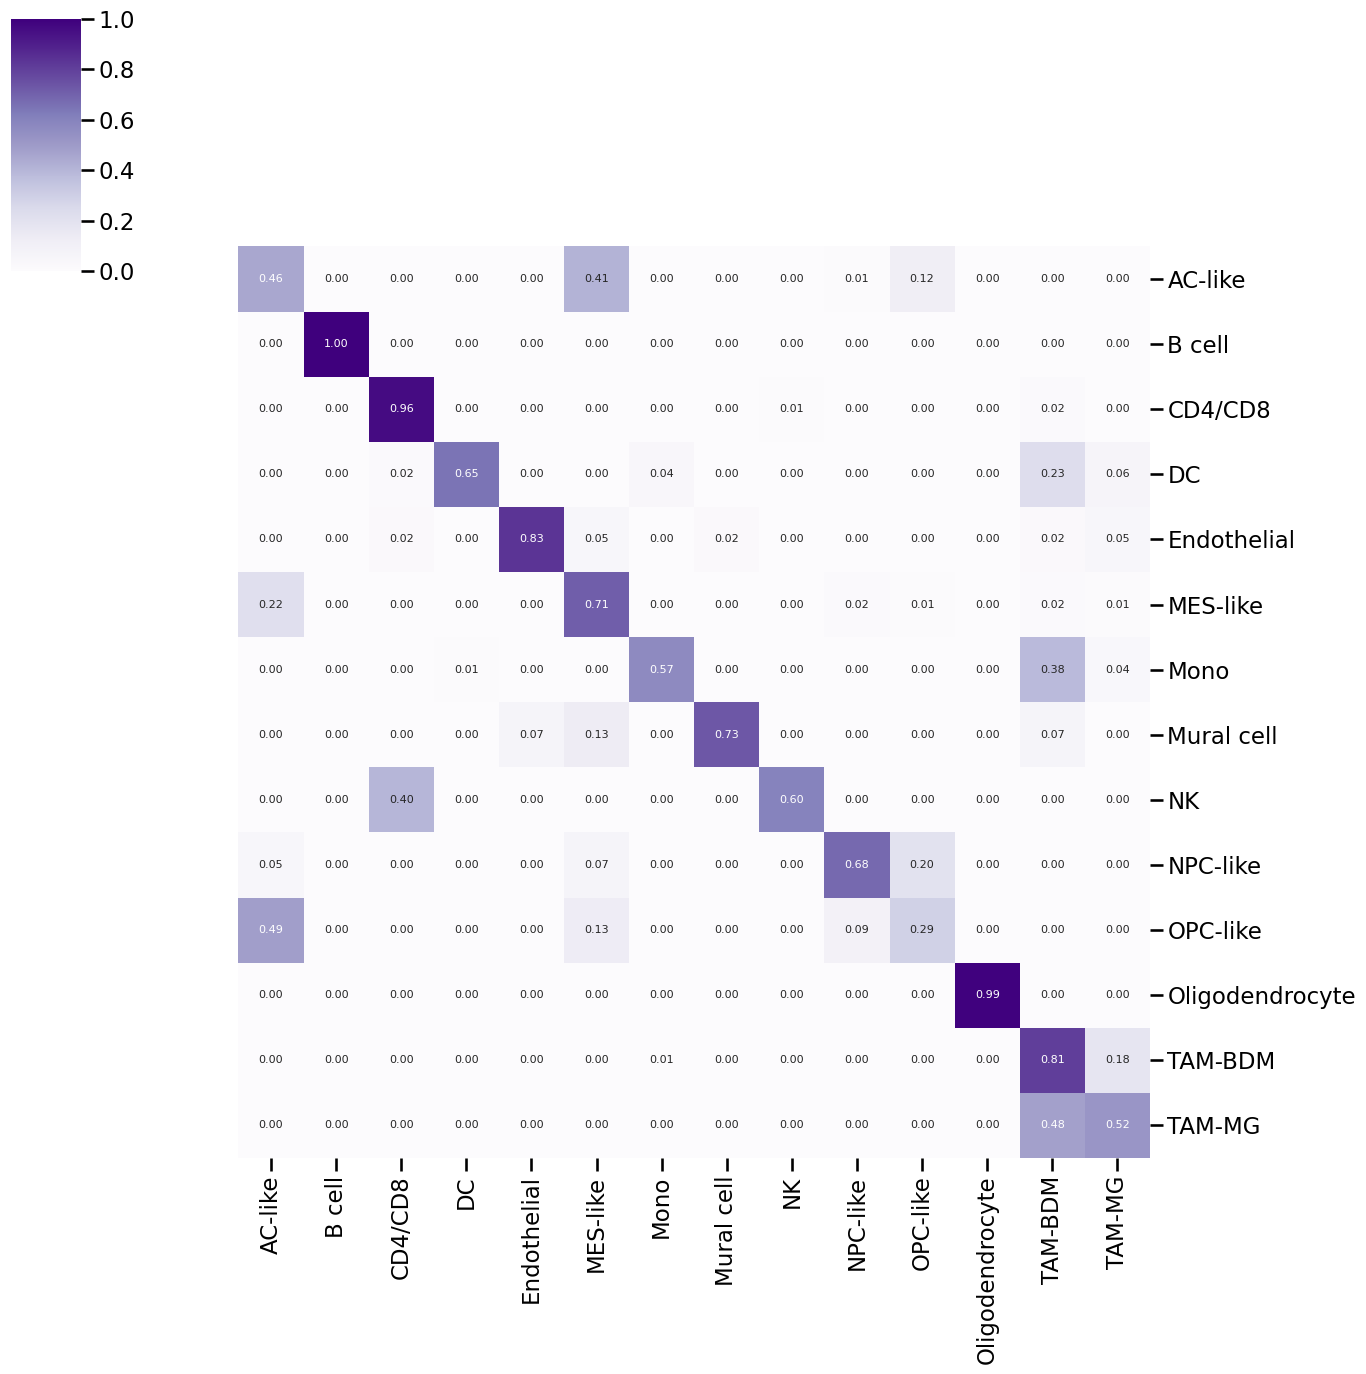

In [ ]:
# Extract true labels and predicted labels
y_true = adata_test.obs[cell_type_key].to_numpy()
y_pred = preds

# Create a list of unique cell types and compute the confusion matrix
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)

# Normalize the confusion matrix to calculate proportions
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

# Convert the matrix to a Pandas DataFrame for visualization
df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

# Generate a heatmap of the confusion matrix
ax = sns.clustermap(
    df,
    cmap='Purples',              # Colour map
    annot=True,                  # Add value annotations
    fmt=".2f",                   # Format annotations to two decimals
    annot_kws={'size': 8},       # Annotation font size
    vmin=0, vmax=1,              # Normalize colormap between 0 and 1
    row_cluster=False,           # Disable row clustering
    col_cluster=False,           # Disable column clustering
    figsize=(14, 14)             # Set figure size
)

## Pip Freeze Packages (Python 3.10.12):

In [11]:
pip freeze

absl-py==1.4.0
accelerate==1.2.1
aiohappyeyeballs==2.4.4
aiohttp==3.11.10
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
altair==5.5.0
anndata==0.11.3
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_api_compat==1.10.0
array_record==0.5.1
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2024.12.16.0.35.48
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==24.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
beautifulsoup4==4.12.3
bigframes==1.29.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==2.7.1
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.43
branca==0.8.1
CacheControl==0.14.1
cached-property==2.0.1
cachetools==5.5.0
catalogue==2.0.10
cell-gears==0.0.2
certifi==2024.12.14
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.0
chex==0.1.88
clarabel==0.9.0
click==8.1.7
cloudpathlib==0.20.0
cloudpickle==3.1.0
cmake==3.31.2
cmdstanpy==1.2.5
colorcet==3.1.0
colorlove

## Data sources (GBMAP)

In [ ]:
# GBMAP datasets: https://cellxgene.cziscience.com/collections/999f2a15-3d7e-440b-96ae-2c806799c08c

# dataset_url = "https://datasets.cellxgene.cziscience.com/95681969-4e6d-4ba7-9854-645308b451e2.h5ad"
# output_path = os.path.join(data_dir, "gbmap.h5ad")
# !wget -O {output_path} "{dataset_url}"

# # URL of the extended GBmap dataset
# url = 'https://datasets.cellxgene.cziscience.com/d36a23ec-65f6-446e-8e69-c72ccbd44d9e.h5ad'

# # Path to save the dataset
# file_path = os.path.join(data_dir, "gbmap", 'extended_gbmap.h5ad')

# # Download the dataset
# !wget -O {file_path} {url}